Dataset: https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import random
from sklearn.tree import export_graphviz
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from graphviz import Source

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("bank.csv")
df['deposit'] = df['deposit'].map({'no': 0, 'yes': 1})

## Is there something wrong with Month??

In [3]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
for month in months:
    df['month_' + month] = df['month'].apply(lambda x: 1 if x.lower() == month else 0)
df.drop(columns=["month"], inplace=True)
for val in df["month_mar"].unique():
    print(val)

0
1


## Handle Binary Features

In [4]:
df['default'] = df['default'].map({'no': 0, 'yes': 1})
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})

## One Hot Encode and Prepare the data

In [5]:
X = df.drop('deposit', axis=1)
y = df['deposit'] 

display(X.columns)
display(X.head())

X = pd.get_dummies(X, dtype=int)

# campaign is a categorical variable, so we need to perform one-hot encoding on it
campaign = pd.get_dummies(X.campaign, prefix='campaign', dtype=int)
dropped = X.drop('campaign', axis=1)

# combine the one-hot encoded campaign with the original features
X = pd.concat([dropped, campaign], axis=1)
continuous_features = X[['age','balance', 'day', 'duration', 'pdays']]

for column in continuous_features:
    X[column] = (X[column] - X[column].mean()) / X[column].std()

X.head()

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'month_jan', 'month_feb', 'month_mar', 'month_apr',
       'month_may', 'month_jun', 'month_jul', 'month_aug', 'month_sep',
       'month_oct', 'month_nov', 'month_dec'],
      dtype='object')

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_mar,month_apr,month_may,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,month_dec
0,59,admin.,married,secondary,0,2343,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,0
1,56,admin.,married,secondary,0,45,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,0
2,41,technician,married,secondary,0,1270,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,0
3,55,services,married,secondary,0,2476,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,0
4,54,admin.,married,tertiary,0,184,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,0


,age,default,balance,housing,loan,day,duration,pdays,previous,month_jan,...,campaign_27,campaign_28,campaign_29,campaign_30,campaign_31,campaign_32,campaign_33,campaign_41,campaign_43,campaign_63
0,1.491438,0,0.252514,1,0,-1.265689,1.930139,-0.481162,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.239620,0,-0.459953,0,0,-1.265689,3.154470,-0.481162,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.019470,0,-0.080157,1,0,-1.265689,2.929770,-0.481162,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.155681,0,0.293749,1,0,-1.265689,0.596339,-0.481162,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.071742,0,-0.416858,0,0,-1.265689,0.867132,-0.481162,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(X.columns)

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'pdays', 'previous', 'month_jan', 'month_feb', 'month_mar', 'month_apr',
       'month_may', 'month_jun', 'month_jul', 'month_aug', 'month_sep',
       'month_oct', 'month_nov', 'month_dec', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'campaign_1',
       'campaign_2', 'campaign_3', 'campaign_4', 'campaign_5', 'campaign_6',
       'campaign_7', 'campaign_8', 'campaign_9', 'campaign_10', 'campaign_11',
       'campaign_12',

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X.values, y)

DecisionTreeClassifier(max_depth=3, random_state=1)

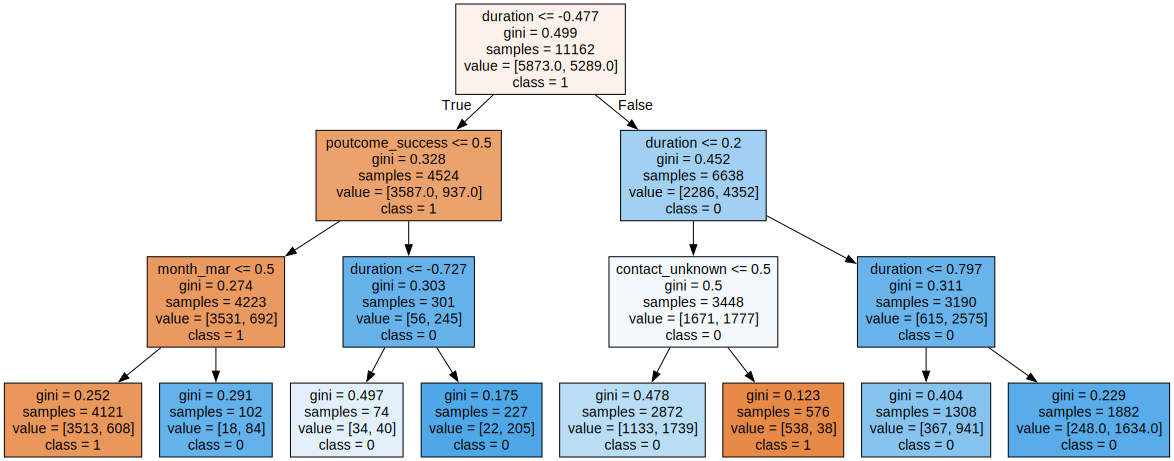

In [8]:
classNames = y.unique().astype(str)
dot = tree.export_graphviz(treeclf, out_file=None,
                           feature_names=X.columns,
                           class_names=classNames, 
                           filled = True)
# display the graph here
graph = Source(dot)
svg = SVG(graph.pipe(format='svg'))
display(svg)

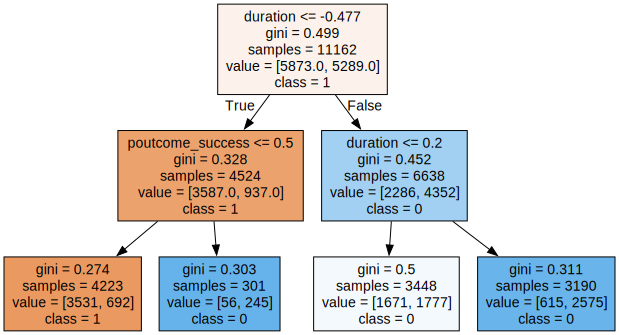

In [9]:
treeclf = DecisionTreeClassifier(max_depth=2, random_state=1)
treeclf.fit(X.values, y)
classNames = y.unique().astype(str)
dot = tree.export_graphviz(treeclf, out_file=None,
                           feature_names=X.columns,
                           class_names=classNames, 
                           filled = True)
# display the graph here
graph = Source(dot)
svg = SVG(graph.pipe(format='svg'))
display(svg)

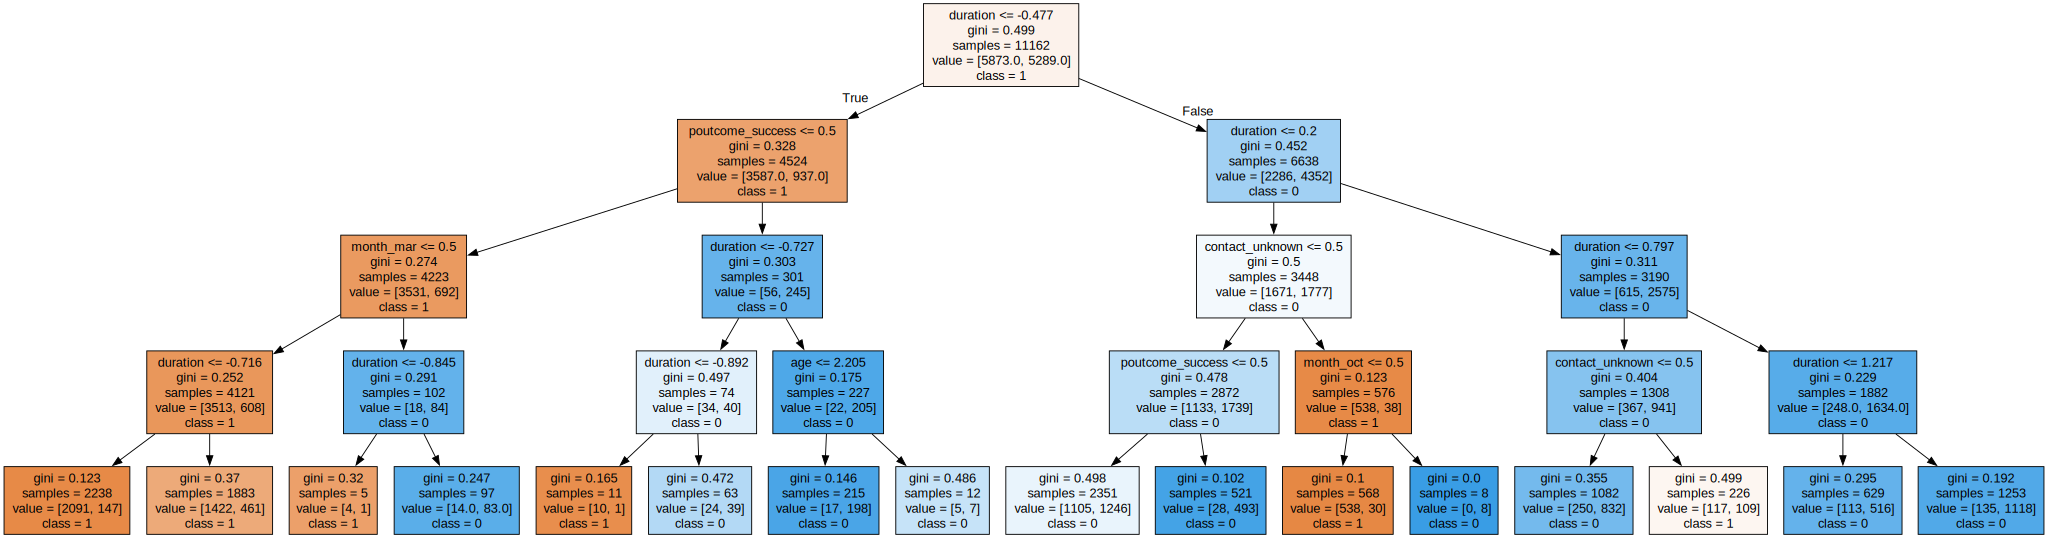

In [10]:
treeclf = DecisionTreeClassifier(max_depth=4, random_state=1)
treeclf.fit(X.values, y)
classNames = y.unique().astype(str)
dot = tree.export_graphviz(treeclf, out_file=None,
                           feature_names=X.columns,
                           class_names=classNames, 
                           filled = True)
# display the graph here
graph = Source(dot)
svg = SVG(graph.pipe(format='svg'))
display(svg)

## Visualize the output

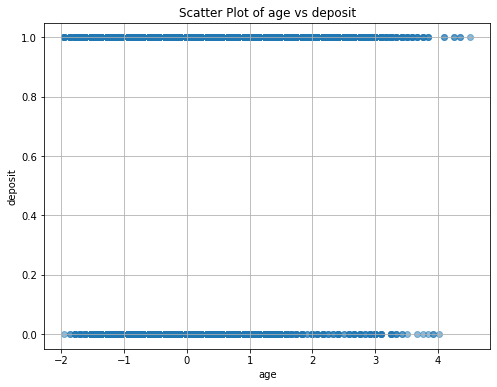

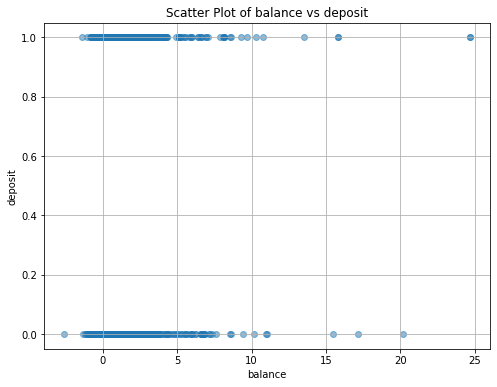

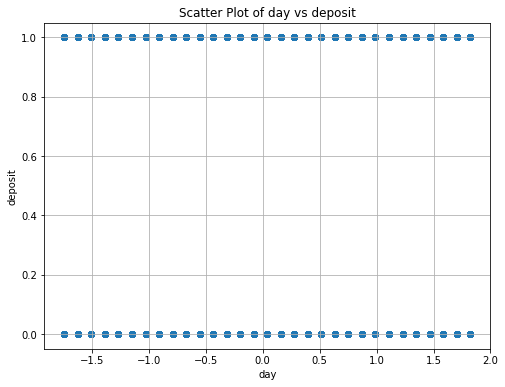

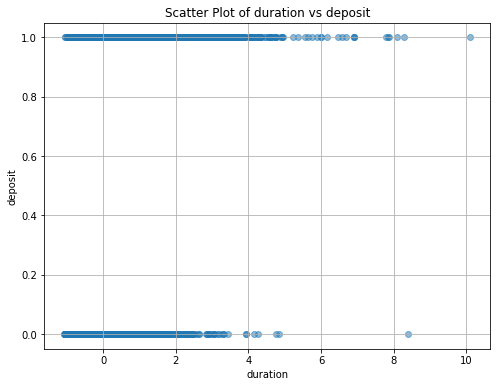

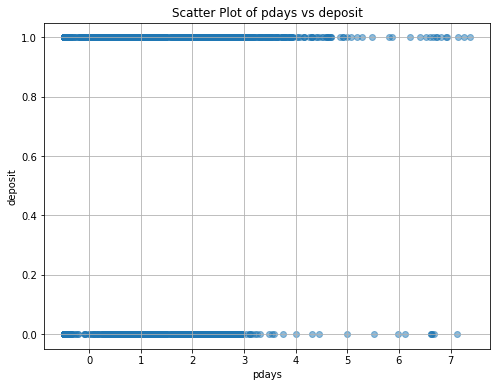

In [11]:
target_variable = 'deposit'
for feature in continuous_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(X[feature], y, alpha=0.5)
    plt.title(f'Scatter Plot of {feature} vs {target_variable}')
    plt.xlabel(feature)
    plt.ylabel(target_variable)
    plt.grid(True)
    plt.show()

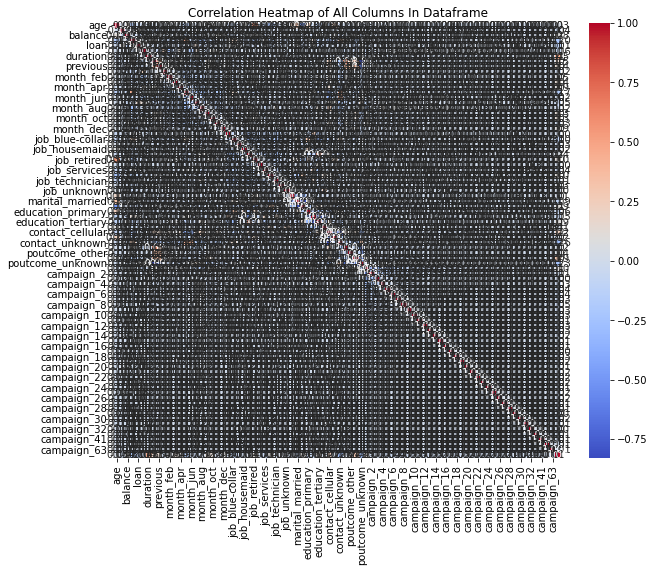

In [12]:
df = pd.concat([X, y], axis=1)
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap of All Columns In Dataframe')
plt.show()

## Remove lots of features that aren't in the decision tree to help when I want to regraph the heatmap since the above graph is unreadable

In [13]:
campaign_columns = df.filter(regex='^campaign_', axis=1).columns
df = df.drop(campaign_columns, axis=1)
job_columns = df.filter(regex='^job_', axis=1).columns
df = df.drop(job_columns, axis=1)

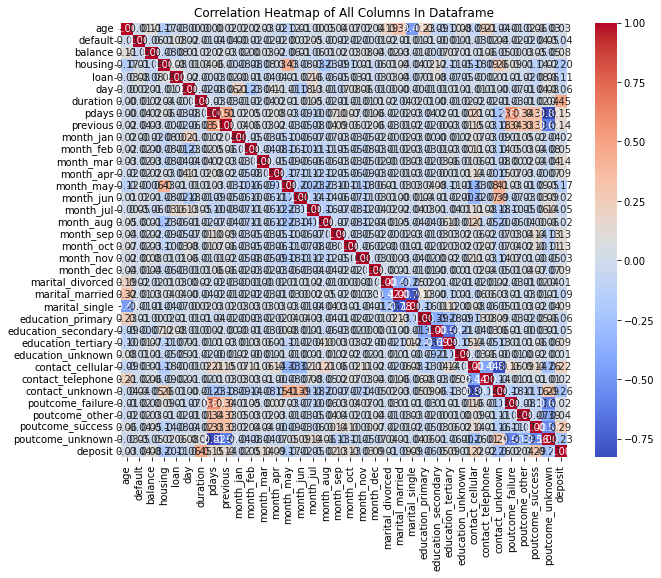

In [14]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap of All Columns In Dataframe')
plt.show()

## Make a Heatmap of just the months compared with the target variable since tyhe above heatmaps were clearly too complicated

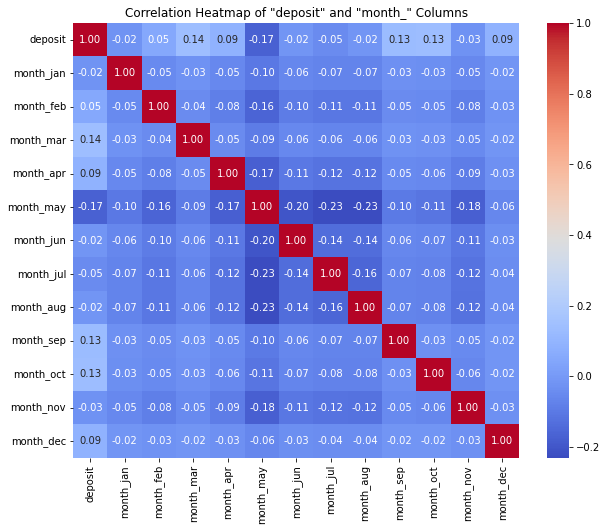

In [15]:
month_columns = df.filter(regex='^month_', axis=1).columns
heatmap_df = df[['deposit'] + list(month_columns)]
correlation_matrix = heatmap_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of "deposit" and "month_" Columns')
plt.show()

## Visualize Heapmap without The Month Correlations With Deposit because we don't want it to be understandable

In [16]:
month_columns = df.filter(regex='^month_', axis=1).columns
df = df.drop(month_columns, axis=1)

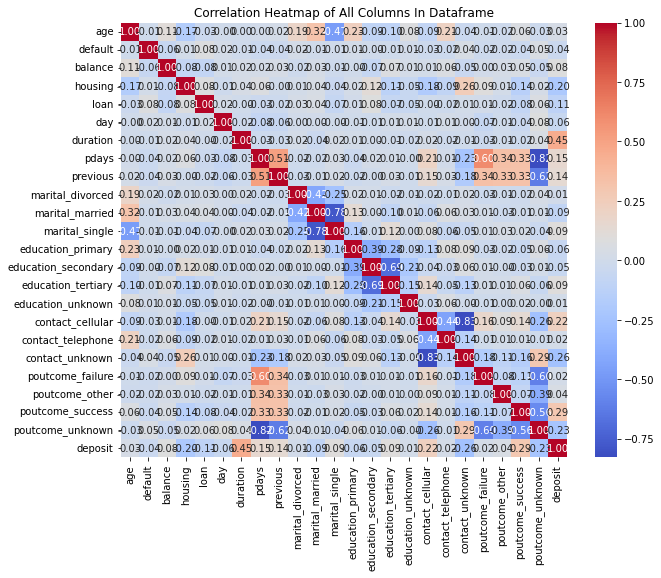

In [17]:
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap of All Columns In Dataframe')
plt.show()

## Make a heatmap to show the different continuous features coorelations to the target variable since heatmapping too many variable again failed miserably

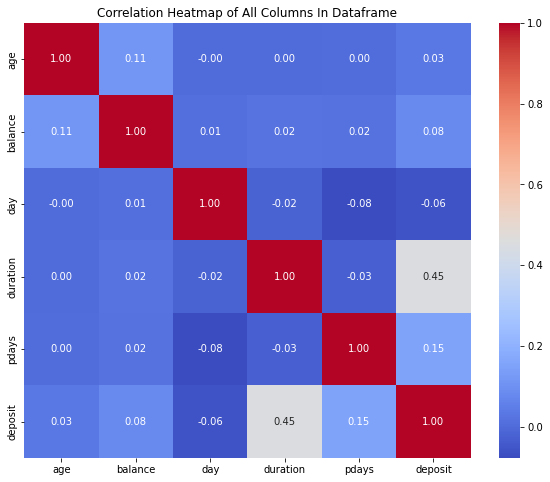

In [18]:
corr_matrix = df[['age', 'balance', 'day', 'duration', 'pdays', 'deposit']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap of All Columns In Dataframe')
plt.show()

Duration: Duration of the last contact to the potential person who will make a deposit in the bank...

## Make A decision tree with just duration

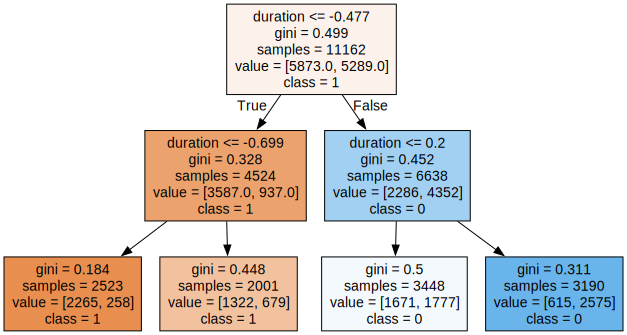

In [19]:
treeclf = DecisionTreeClassifier(max_depth=2, random_state=1)
treeclf.fit(X[["duration"]].values, y)
classNames = y.unique().astype(str)
dot = tree.export_graphviz(treeclf, out_file=None,
                           feature_names=X[["duration"]].columns,
                           class_names=classNames, 
                           filled = True)
# display the graph here
graph = Source(dot)
svg = SVG(graph.pipe(format='svg'))
display(svg)

# Neural Networks

In [20]:
df = pd.read_csv("bank.csv")
df['deposit'] = df['deposit'].map({'no': 0, 'yes': 1})

In [21]:
X = df.drop('deposit', axis=1)  # Drop the target variable to get the features
y = df['deposit']  # Select only the target variable

# Display the original DataFrame
# print("Original DataFrame:")
# print(df.head())
display(X.columns)
display(X.head())



# Perform one-hot encoding on the features
X = pd.get_dummies(X, dtype=int)
X = X.drop('campaign', axis=1)

# uncomment this code if you want to try encoding with the campaign
# # campaign is a categorical variable, so we need to perform one-hot encoding on it
# campaign = pd.get_dummies(X.campaign, prefix='campaign', dtype=int)
# dropped = X.drop('campaign', axis=1)

# # combine the one-hot encoded campaign with the original features
# X = pd.concat([dropped, campaign], axis=1)



continuous_features = X[['age','balance', 'day', 'duration', 'pdays']]

for column in continuous_features:
    X[column] = (X[column] - X[column].mean()) / X[column].std()

X.head()

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown


,age,balance,day,duration,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.491438,0.252514,-1.265689,1.930139,-0.481162,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1.239620,-0.459953,-1.265689,3.154470,-0.481162,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.019470,-0.080157,-1.265689,2.929770,-0.481162,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1.155681,0.293749,-1.265689,0.596339,-0.481162,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1.071742,-0.416858,-1.265689,0.867132,-0.481162,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

mlp = MLPClassifier(hidden_layer_sizes=(10),max_iter=500) # 1 layer, 5 nodes

mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

In [23]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1456
           1       0.83      0.86      0.84      1335

    accuracy                           0.85      2791
   macro avg       0.85      0.85      0.85      2791
weighted avg       0.85      0.85      0.85      2791



In [24]:
print('This dataset has {} input nodes and {} output node(s)'.format(len(X.columns), len(y.unique())))
print('There are {} 2D arrays of coefficients, one for each layer'.format(len(mlp.coefs_)))
print('The layers have the following number of coefficients: {}')
for l in range(len(mlp.coefs_)):
    m = len(mlp.coefs_[l])
    n = len(mlp.coefs_[l][0])
    print('  {}: {}x{} ({} nodes feeding into a layer of {} nodes)'.format(l, m, n, m, n))
# Print the actual coefficients
# print(mlp.coefs_)

print()
print('There are {} 1D arrays of intercepts, one for each layer'.format(len(mlp.intercepts_)))
print('Each layer has {} intercepts, one for each node'.format([len(mlp.intercepts_[l]) for l,_ in enumerate(mlp.intercepts_)]))


This dataset has 50 input nodes and 2 output node(s)
There are 2 2D arrays of coefficients, one for each layer
The layers have the following number of coefficients: {}
  0: 50x10 (50 nodes feeding into a layer of 10 nodes)
  1: 10x1 (10 nodes feeding into a layer of 1 nodes)

There are 2 1D arrays of intercepts, one for each layer
Each layer has [10, 1] intercepts, one for each node


In [25]:
# you may need to install networkx with pip
import networkx as nx
import colorsys

def show_ann(mlp):
    hidden_layers_n = len(mlp.coefs_)-1
    layers_n = hidden_layers_n + 2
    input_neurons_n = len(mlp.coefs_[0])
    hidden_neurons_n = [len(mlp.coefs_[i+1]) for i in range(hidden_layers_n)]
    output_neurons_n = len(mlp.coefs_[-1][0])

    G = nx.DiGraph()
    pos = {}

    # Create the neurons of the input layer
    for i in range(input_neurons_n):
        pos['Layer0_{}'.format(i)] = (i,layers_n-1)

    for j in range(hidden_layers_n):
        # Create the neurons of the j'th hidden layer
        prev_layer = j
        cur_layer = j+1
        if (j == 0):
            prev_size = input_neurons_n
        else:
            prev_size = hidden_neurons_n[j-1]
        for i in range(hidden_neurons_n[j]):
            pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
            for k in range(prev_size):
                w = mlp.coefs_[prev_layer][k][i]
                G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    # Create the neurons of the output layer
    prev_layer = hidden_layers_n
    cur_layer = hidden_layers_n+1
    for i in range(output_neurons_n):
        pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
        for k in range(hidden_neurons_n[-1]):
            w = mlp.coefs_[prev_layer][k][i]
            G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)

    edges = G.edges()
    colors = [colorsys.hsv_to_rgb(0 if G[u][v]['weight'] < 0 else 0.65,
                                  1,#min(1, abs(G[u][v]['weight'])),
                                  1) for u,v in edges]
    weights = [abs(G[u][v]['weight'])*2 for u,v in edges]

    nx.draw(G, pos, node_color='y', node_size=450, width=weights, edge_color=colors)
    
show_ann(mlp)

TypeError: '_AxesStack' object is not callable

<Figure size 432x288 with 0 Axes>

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10),max_iter=500) # 1 layer, 5 nodes

mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(classification_report(y_test,predictions))

In [ ]:
print('This dataset has {} input nodes and {} output node(s)'.format(len(X.columns), len(y.unique())))
print('There are {} 2D arrays of coefficients, one for each layer'.format(len(mlp.coefs_)))
print('The layers have the following number of coefficients: {}')
for l in range(len(mlp.coefs_)):
    m = len(mlp.coefs_[l])
    n = len(mlp.coefs_[l][0])
    print('  {}: {}x{} ({} nodes feeding into a layer of {} nodes)'.format(l, m, n, m, n))
# Print the actual coefficients
# print(mlp.coefs_)

print()
print('There are {} 1D arrays of intercepts, one for each layer'.format(len(mlp.intercepts_)))
print('Each layer has {} intercepts, one for each node'.format([len(mlp.intercepts_[l]) for l,_ in enumerate(mlp.intercepts_)]))

In [ ]:
show_ann(mlp)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(20, 10, 5),max_iter=500) # 1 layer, 5 nodes

mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(classification_report(y_test,predictions))

In [ ]:
print('This dataset has {} input nodes and {} output node(s)'.format(len(X.columns), len(y.unique())))
print('There are {} 2D arrays of coefficients, one for each layer'.format(len(mlp.coefs_)))
print('The layers have the following number of coefficients: {}')
for l in range(len(mlp.coefs_)):
    m = len(mlp.coefs_[l])
    n = len(mlp.coefs_[l][0])
    print('  {}: {}x{} ({} nodes feeding into a layer of {} nodes)'.format(l, m, n, m, n))
# Print the actual coefficients
# print(mlp.coefs_)

print()
print('There are {} 1D arrays of intercepts, one for each layer'.format(len(mlp.intercepts_)))
print('Each layer has {} intercepts, one for each node'.format([len(mlp.intercepts_[l]) for l,_ in enumerate(mlp.intercepts_)]))

In [ ]:
show_ann(mlp)